In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Modelo Var

De acuerdo a lo solicitado se desarrolla el modelo VAR con cada uno de los pasos necesarios para su aplicación efectiva

In [2]:
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
library(dplyr)
library(stats)
library(MTS)
library(urca)
library(vars)
library(tsDyn)
options(warn = - 1) 

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘PerformanceAnalytics’


The following objects are masked from ‘package:fBasics’:

    kurtosis, skewness


The following object is masked from ‘package:graphics’:

    legend


Loading required package: TTR


Attaching package: ‘TTR’


The following object is masked from ‘package:fBasics’:

    volatility


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                        

### Carga de información

Se procede a cargar la información de los precios de cierre de RYLD, TSLA, TM y GM del 22-04-2019 al 31-12-2022

In [3]:
# Especificamos las fechas de inicio y fin.
start<-format(as.Date("2019-04-22"),"%Y-%m-%d")
end<-format(as.Date("2022-12-31"),"%Y-%m-%d")

#Se crea la función para traer la información de yahoo finance
precio<-function(simbolo) {
  ##---------Obtener precios de yahoo finance:
  datos<-getSymbols(simbolo,  from=start, to= end, auto.assign = FALSE)
  ##---------eliminar datos faltantes:
  datos<-na.omit(datos)
  ##--------Mantener el precio de interis:
  datos<-datos[,4]
  assign(simbolo, datos, envir = .GlobalEnv)
}

In [4]:
### Importamos la información

precio("RYLD")   
precio("TSLA") 
precio("TM")
precio("GM")


In [5]:
## Juntamos la información
prices<-merge.xts(`RYLD`,`TSLA`, `TM`, `GM`,join='inner')%>% na.omit()
dim(prices)
## Cambiamos los nombres de las columnas
colnames(prices)<-c("RYLD", "TSLA", "TM", "GM")
head(prices)

[1] 933   4

             RYLD     TSLA     TM    GM
2019-04-22 24.995 17.51667 124.16 39.50
2019-04-23 25.157 17.59333 124.94 39.83
2019-04-24 25.189 17.24400 122.88 39.72
2019-04-25 25.130 16.50867 123.19 39.11
2019-04-26 25.225 15.67600 123.62 39.68
2019-04-29 25.250 16.09800 123.81 40.01

In [6]:
class(prices)

[1] "xts" "zoo"

In [7]:
dygraph(prices, main = "RYLD, TSLA, TM, GM") %>%
  dyAxis("y", label = "Prices") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))

HTML widgets cannot be represented in plain text (need html)

### Partición de la información

Se procede a partir la información en entrenamiento y prueba con los valores de prueba equivaliendo a un 5%

In [31]:
## Se traspasa al formato ts
precio.ts <- ts(prices, start = c(2017, 5), frequency = 365)

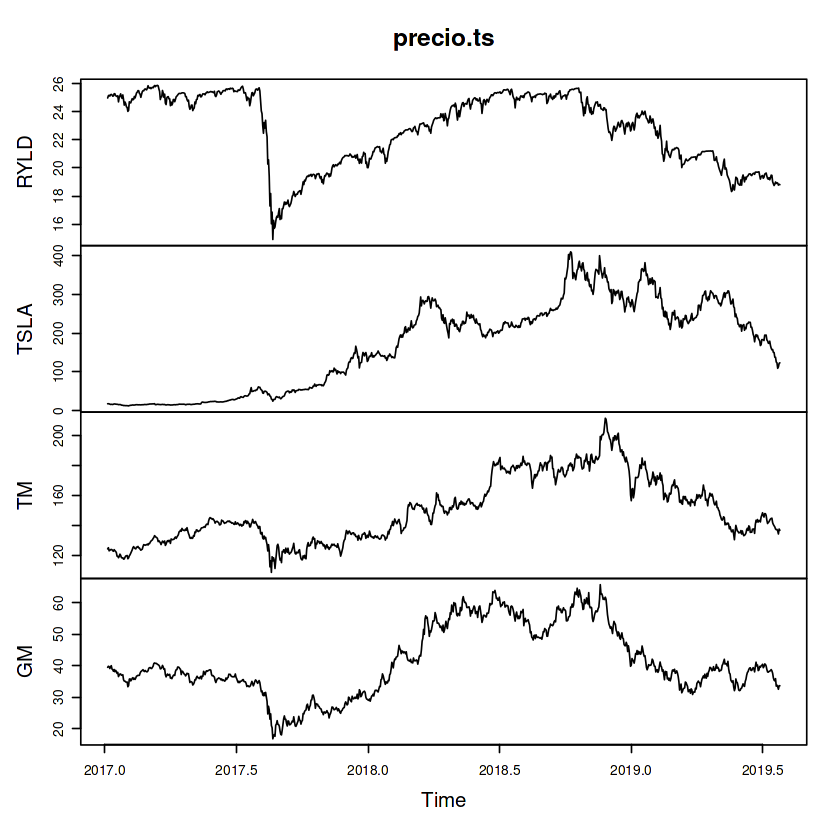

In [32]:
plot(precio.ts)

In [33]:
## Se parte la serie de acuerdo a lo establecido en el problema con un 5% como prueba
#Partimos serie para train & test
Pr <- precio.ts
h <- round(length(Pr)*0.05, digits = 0 )
h
Pr_tra <- Pr[1:(nrow(Pr) - h), ]
Pr_tes<- Pr[(nrow(Pr) - h + 1):nrow(Pr), ]

[1] 187

In [41]:
Pr_tra.ts <- ts(Pr_tra, start = c(2017, 5), frequency = 365)
Pr_tes.ts <- ts(Pr_tra, start = c(2017, 5), frequency = 365)

In [42]:
## ya que algunos de los comportamiento son exponenciales se realiza la transformación
gdp=log(Pr_tra.ts)
gdp_test=log(Pr_tes.ts)

### Identificación de nivel regresivo y prueba de cointegración

In [43]:
#Identificamos el nivel regresivo, mediante la función VARselect
nivelka=VARselect(Pr_tra, lag.max = 7, type = "const")
nivelka$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      3      1      3

In [44]:
niv1=VARorder(Pr_tra)

selected order: aic =  3 
selected order: bic =  1 
selected order: hq =  3 
Summary table:  
       p     AIC     BIC      HQ       M(p) p-value
 [1,]  0 18.8819 18.8819 18.8819     0.0000  0.0000
 [2,]  1  2.4890  2.5880  2.5271 11957.0417  0.0000
 [3,]  2  2.4554  2.6534  2.5317    55.3367  0.0000
 [4,]  3  2.3924  2.6893  2.5068    76.1866  0.0000
 [5,]  4  2.4247  2.8206  2.5773     7.5769  0.9605
 [6,]  5  2.4303  2.9252  2.6210    26.5493  0.0468
 [7,]  6  2.4300  3.0238  2.6588    30.5917  0.0152
 [8,]  7  2.4453  3.1382  2.7124    19.3494  0.2510
 [9,]  8  2.4361  3.2279  2.7412    36.5027  0.0025
[10,]  9  2.4435  3.3342  2.7868    24.6839  0.0756
[11,] 10  2.4472  3.4370  2.8287    27.0499  0.0409
[12,] 11  2.4623  3.5510  2.8819    19.1585  0.2605
[13,] 12  2.4681  3.6558  2.9259    25.3307  0.0642
[14,] 13  2.4770  3.7636  2.9729    23.1266  0.1104


In [45]:
#La función para la prueba de cointegraci´n es la de ca-jo().
#K es el número de lags para emplear en el modelo autorregresivo
johatest=ca.jo(Pr_tra, type = "trace", K=3, ecdet ="none", spec = "longrun") #
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 2.839947e-02 1.267134e-02 5.232264e-03 1.451805e-06

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  0.00  6.50  8.18 11.65
r <= 2 |  3.90 15.66 17.95 23.52
r <= 1 | 13.37 28.71 31.52 37.22
r = 0  | 34.78 45.23 48.28 55.43

Eigenvectors, normalised to first column:
(These are the cointegration relations)

            RYLD.l3     TSLA.l3        TM.l3       GM.l3
RYLD.l3  1.00000000  1.00000000  1.000000000  1.00000000
TSLA.l3  0.04436906  0.01722703 -0.002530138  0.12910910
TM.l3   -0.19411746  0.10377740 -0.005376956  0.09923913
GM.l3   -0.17663363 -0.50169462 -0.016545329 -0.32907108

Weights W:
(This is the loading matrix)

           RYLD.l3      TSLA.l3        TM.l3         GM.l3
RYLD.d 0.001910637 -0.003668050 -0.007842805 -3.561206e-06
TSLA.d 0.032851818  0.158873545 -0.077437460 -5.23

Como podemos observar, el estadístico de prueba en r=0, es menor a todos los resultados de significancia de la prueba cuando r=0. Si continuamos, la hipótesis para el rango de uno, se acepta al 5% de significancia. Por lo cual, no existe a la cointegración en el sistema.

### Diferenciación de la serie


De acuerdo con lo solicitado se procede a realizar la diferenciación de la serie para hacerlas estacionarias

In [46]:
# Importamos la librería de tserires para la aplicación de la prueba de Dickey Fuller.
library(tseries)
adf.test(Pr_tra[,1])
adf.test(Pr_tra[,2])
adf.test(Pr_tra[,3])
adf.test(Pr_tra[,4])


	Augmented Dickey-Fuller Test

data:  Pr_tra[, 1]
Dickey-Fuller = -2.0574, Lag order = 9, p-value = 0.554
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  Pr_tra[, 2]
Dickey-Fuller = -3.1202, Lag order = 9, p-value = 0.1041
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  Pr_tra[, 3]
Dickey-Fuller = -2.6275, Lag order = 9, p-value = 0.3127
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  Pr_tra[, 4]
Dickey-Fuller = -1.6518, Lag order = 9, p-value = 0.7257
alternative hypothesis: stationary


Como se puede observar de los resultados de la prueba Dickey_Fuller, las series no son estacionarias ya que el p-valor en cada uno de los resultados, muestran la presencia de una raíz unitaria. Con ello, debemos proceder a diferenciar las series.

In [47]:
### Se procede a realizar la diferenciación
ryld=diff(gdp[,1],1)
tsla=diff((gdp[,2]),1)
tm=diff(gdp[,3],1)
gm=diff(gdp[,4],1)
z=cbind.data.frame(ryld,tsla,tm,gm)
head(z)
str(z)

,ryld,tsla,tm,gm
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0064603330,0.004367189,0.006262556,0.008319771
2,0.0012711871,-0.020055756,-0.016625395,-0.002765573
3,-0.0023450404,-0.043578712,0.002519652,-0.015476666
4,0.0037732632,-0.051754658,0.003484468,0.014469086
5,0.0009905744,0.026564157,0.001535746,0.008282091
6,-0.0015457310,-0.011579538,-0.001697580,-0.026850589


'data.frame':	745 obs. of  4 variables:
 $ ryld: Time-Series  from 2017 to 2019: 0.00646 0.001271 -0.002345 0.003773 0.000991 ...
 $ tsla: Time-Series  from 2017 to 2019: 0.00437 -0.02006 -0.04358 -0.05175 0.02656 ...
 $ tm  : Time-Series  from 2017 to 2019: 0.00626 -0.01663 0.00252 0.00348 0.00154 ...
 $ gm  : Time-Series  from 2017 to 2019: 0.00832 -0.00277 -0.01548 0.01447 0.00828 ...


### Modelación con VARS

Con la diferenciación compeltada se procede a hacer la modelación con VARS con base en la información brindada en el Tutorial

In [48]:
# En la librería de VAR, la función que permite identificar el orden regresivo es la función de VARselect(). Se elige el máximo de rezagos de lag.max=7.
nivelk=VARselect(z, lag.max = 7, type = "const")
nivelk$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     6      2      1      6

In [49]:
#Podemos volver a llamar la librería de vars y aplicar el regresión habiendo encontrado que p=2.
library(vars)
m0=vars::VAR(z, p=2)
summary(m0)


VAR Estimation Results:
Endogenous variables: ryld, tsla, tm, gm 
Deterministic variables: const 
Sample size: 743 
Log Likelihood: 7594.66 
Roots of the characteristic polynomial:
0.6839 0.4592 0.2834 0.2834 0.1694 0.1694 0.1552 0.1552
Call:
vars::VAR(y = z, p = 2)


Estimation results for equation ryld: 
ryld = ryld.l1 + tsla.l1 + tm.l1 + gm.l1 + ryld.l2 + tsla.l2 + tm.l2 + gm.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
ryld.l1 -2.104e-01  5.036e-02  -4.177 3.32e-05 ***
tsla.l1  1.215e-02  1.210e-02   1.004   0.3156    
tm.l1   -2.693e-02  3.720e-02  -0.724   0.4693    
gm.l1    2.684e-02  2.160e-02   1.243   0.2143    
ryld.l2  3.596e-01  5.030e-02   7.149 2.11e-12 ***
tsla.l2 -5.524e-03  1.209e-02  -0.457   0.6480    
tm.l2    3.635e-02  3.727e-02   0.975   0.3296    
gm.l2   -5.391e-02  2.129e-02  -2.532   0.0116 *  
const   -7.968e-05  4.630e-04  -0.172   0.8634    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 

Como se puede observar: 
* En el caso de TSLA este depende del segundo rezago de RYLD.
* RYLD depende del primer y segundo rezago del mismo stock y del segundo rezago de GM
* TM depende de unicamente del primer rezago de RYLD
* GM depende del primer rezago de TSLA y TM

### Modelación con libreria MTS

In [50]:
# En la librería de MTS, la función que permite la identificación del nivel regresivo es VARorder().
VARorder(z)

selected order: aic =  7 
selected order: bic =  0 
selected order: hq =  2 
Summary table:  
       p      AIC      BIC       HQ     M(p) p-value
 [1,]  0 -31.4804 -31.4804 -31.4804   0.0000  0.0000
 [2,]  1 -31.5719 -31.4729 -31.5338  97.6885  0.0000
 [3,]  2 -31.6706 -31.4725 -31.5942 102.3175  0.0000
 [4,]  3 -31.6631 -31.3659 -31.5486  25.4975  0.0615
 [5,]  4 -31.6651 -31.2688 -31.5124  32.1061  0.0097
 [6,]  5 -31.6771 -31.1817 -31.4861  39.0136  0.0011
 [7,]  6 -31.6835 -31.0890 -31.4544  34.8909  0.0041
 [8,]  7 -31.6837 -30.9902 -31.4164  30.3227  0.0164
 [9,]  8 -31.6678 -30.8751 -31.3623  18.8631  0.2758
[10,]  9 -31.6606 -30.7689 -31.3169  24.8736  0.0721
[11,] 10 -31.6418 -30.6510 -31.2599  16.6259  0.4102
[12,] 11 -31.6225 -30.5326 -31.2024  16.2517  0.4355
[13,] 12 -31.6137 -30.4248 -31.1554  23.3283  0.1052
[14,] 13 -31.6096 -30.3216 -31.1132  26.3827  0.0489


De acuerdo con estos resultados el nivel regresivo es p=2

In [51]:
#Se aplica la función de VAR, para generar el modelo de regresión:
m1=MTS::VAR(z,2)

Constant term: 
Estimates:  -7.96829e-05 0.004314666 0.0005039651 -9.582736e-05 
Std.Error:  0.0004629492 0.00159881 0.0005564248 0.00106536 
AR coefficient matrix 
AR( 1 )-matrix 
         [,1]    [,2]    [,3]   [,4]
[1,] -0.21035 0.01215 -0.0269 0.0268
[2,]  0.00561 0.02210 -0.1070 0.0116
[3,] -0.20146 0.00797  0.0267 0.0284
[4,] -0.10724 0.05803 -0.1820 0.0571
standard error 
       [,1]   [,2]   [,3]   [,4]
[1,] 0.0504 0.0121 0.0372 0.0216
[2,] 0.1739 0.0418 0.1285 0.0746
[3,] 0.0605 0.0145 0.0447 0.0260
[4,] 0.1159 0.0278 0.0856 0.0497
AR( 2 )-matrix 
       [,1]     [,2]    [,3]    [,4]
[1,] 0.3596 -0.00552  0.0364 -0.0539
[2,] 0.5543 -0.04437  0.0891 -0.0856
[3,] 0.0493 -0.01128  0.0243  0.0311
[4,] 0.2205  0.02047 -0.0323 -0.0240
standard error 
       [,1]   [,2]   [,3]   [,4]
[1,] 0.0503 0.0121 0.0373 0.0213
[2,] 0.1737 0.0418 0.1287 0.0735
[3,] 0.0605 0.0145 0.0448 0.0256
[4,] 0.1157 0.0278 0.0858 0.0490
  
Residuals cov-mtx: 
             [,1]         [,2]         [,3]     

Ljung-Box Statistics:  
         m       Q(m)     df    p-value
 [1,]   1.00      1.70  -20.00        1
 [2,]   2.00      6.24   -4.00        1
 [3,]   3.00     22.44   12.00        1
 [4,]   4.00     54.39   28.00        0
 [5,]   5.00     87.45   44.00        0
 [6,]   6.00    118.34   60.00        0
 [7,]   7.00    153.71   76.00        0
 [8,]   8.00    176.88   92.00        0
 [9,]   9.00    210.49  108.00        0
[10,]  10.00    231.30  124.00        0
[11,]  11.00    246.33  140.00        0
[12,]  12.00    269.69  156.00        0
[13,]  13.00    289.40  172.00        0
[14,]  14.00    318.22  188.00        0
[15,]  15.00    347.68  204.00        0
[16,]  16.00    378.89  220.00        0
[17,]  17.00    408.86  236.00        0
[18,]  18.00    423.38  252.00        0
[19,]  19.00    465.47  268.00        0
[20,]  20.00    481.05  284.00        0
[21,]  21.00    501.45  300.00        0
[22,]  22.00    520.59  316.00        0
[23,]  23.00    538.08  332.00        0
[24,]  24.00    

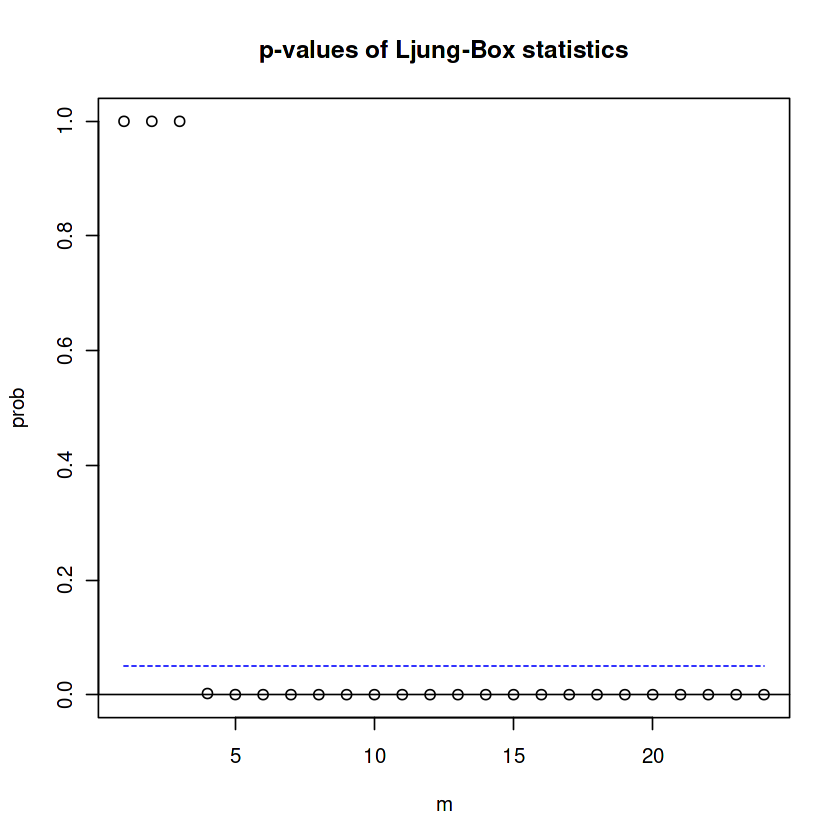

In [52]:
#Se separan los residuales del modelo de regresión y se aplica la función de mq() para la revisión de la calidad del modelo.
#Los grados de libertad del modelo son 32 (2 matrices autorregresivas de 16 coeficientes, cada uno, mas 4 ordenadas).
resi=m1$residuals
mq(resi, adj=36)

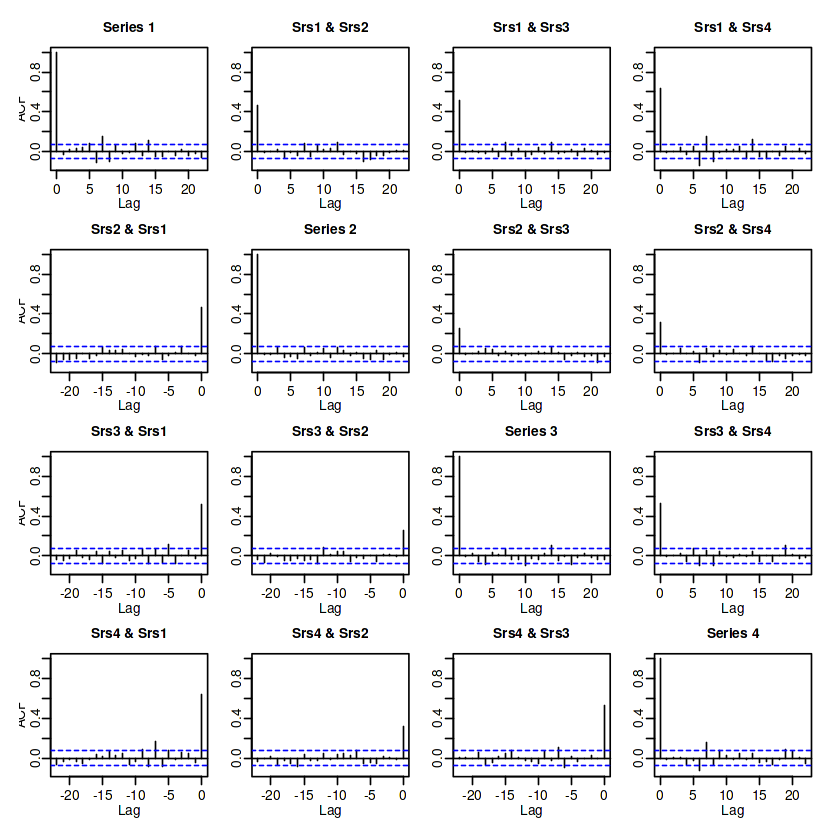

In [53]:
#Se procede a visualizar los rezagos de los residuales, buscando rezagos no capturados por el modelo.
acf(resi) 

Se puede obervar que existen p valores bajos de residuales y rezagos en los modelos que violan la significancia. Con ello, podemos optar por elegir un modelo más complejo o también, elegir primeramente si mediante el refinamiento del mismo, el modelo mejora.

#### Simplificación del modelo

Con base en lo anterior se procede a simplificar el modelo

In [54]:
# Se aplica la función refVAR() para la simplificación.
m2=refVAR(m1,thres = 1.96)

Constant term: 
Estimates:  0 0.004197386 0 0 
Std.Error:  0 0.001573455 0 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1]   [,2]   [,3] [,4]
[1,] -0.171 0.0000  0.000    0
[2,]  0.000 0.0000  0.000    0
[3,] -0.147 0.0000  0.000    0
[4,]  0.000 0.0545 -0.171    0
standard error 
       [,1]   [,2]   [,3] [,4]
[1,] 0.0349 0.0000 0.0000    0
[2,] 0.0000 0.0000 0.0000    0
[3,] 0.0406 0.0000 0.0000    0
[4,] 0.0000 0.0251 0.0725    0
AR( 2 )-matrix 
      [,1] [,2] [,3]    [,4]
[1,] 0.376    0    0 -0.0494
[2,] 0.436    0    0  0.0000
[3,] 0.000    0    0  0.0486
[4,] 0.224    0    0  0.0000
standard error 
       [,1] [,2] [,3]   [,4]
[1,] 0.0445    0    0 0.0203
[2,] 0.1161    0    0 0.0000
[3,] 0.0000    0    0 0.0191
[4,] 0.0782    0    0 0.0000
  
Residuals cov-mtx: 
             [,1]         [,2]         [,3]         [,4]
[1,] 1.537870e-04 0.0002490045 9.529053e-05 0.0002246290
[2,] 2.490045e-04 0.0018344952 1.623764e-04 0.0003864126
[3,] 9.529053e-05 0.0001623764 2.226048e-

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      10.2     6.0     1.00
 [2,]   2.0      27.2    22.0     0.21
 [3,]   3.0      41.5    38.0     0.32
 [4,]   4.0      72.0    54.0     0.05
 [5,]   5.0     103.5    70.0     0.01
 [6,]   6.0     134.0    86.0     0.00
 [7,]   7.0     169.0   102.0     0.00
 [8,]   8.0     190.6   118.0     0.00
 [9,]   9.0     223.8   134.0     0.00
[10,]  10.0     244.6   150.0     0.00
[11,]  11.0     260.5   166.0     0.00
[12,]  12.0     281.1   182.0     0.00
[13,]  13.0     300.3   198.0     0.00
[14,]  14.0     329.8   214.0     0.00
[15,]  15.0     359.8   230.0     0.00
[16,]  16.0     390.6   246.0     0.00
[17,]  17.0     422.7   262.0     0.00
[18,]  18.0     438.0   278.0     0.00
[19,]  19.0     479.4   294.0     0.00
[20,]  20.0     494.7   310.0     0.00
[21,]  21.0     514.4   326.0     0.00
[22,]  22.0     535.1   342.0     0.00
[23,]  23.0     553.0   358.0     0.00
[24,]  24.0     580.2   374.0     0.00


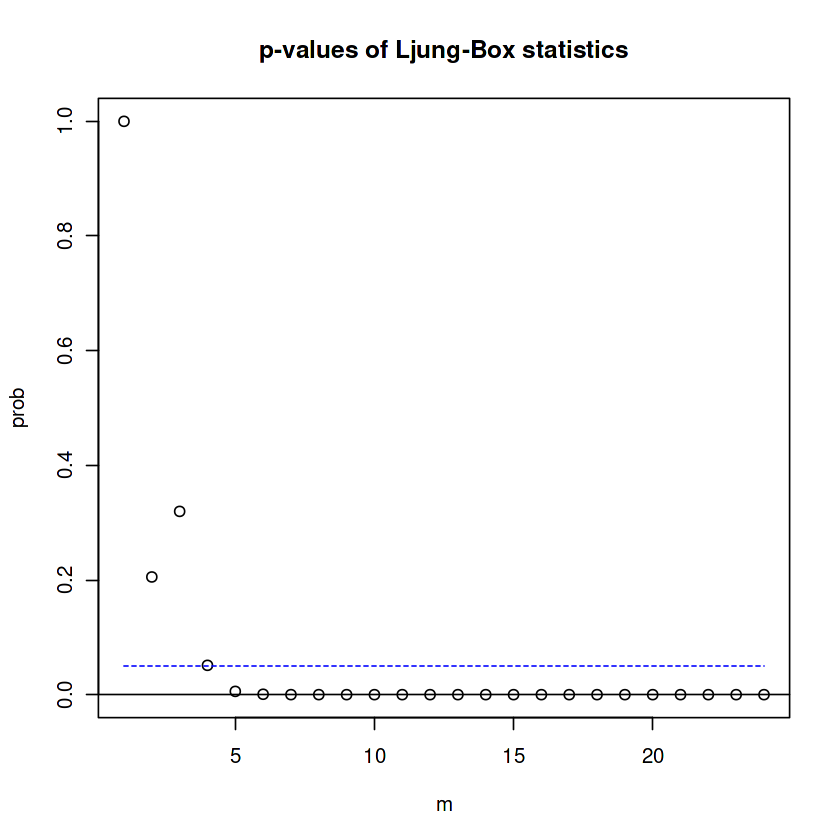

In [55]:
## Se procede a revisar los residuales. Tomando en cuenta los ajustes se tiene 1 ordenada significativa y 9 parametros regresivos
# Separamos nuevamente los residuales del modelo refinado y aplicamos función de revisión mediante función mq()
resi2=m2$residuals
mq(resi2, adj=10)

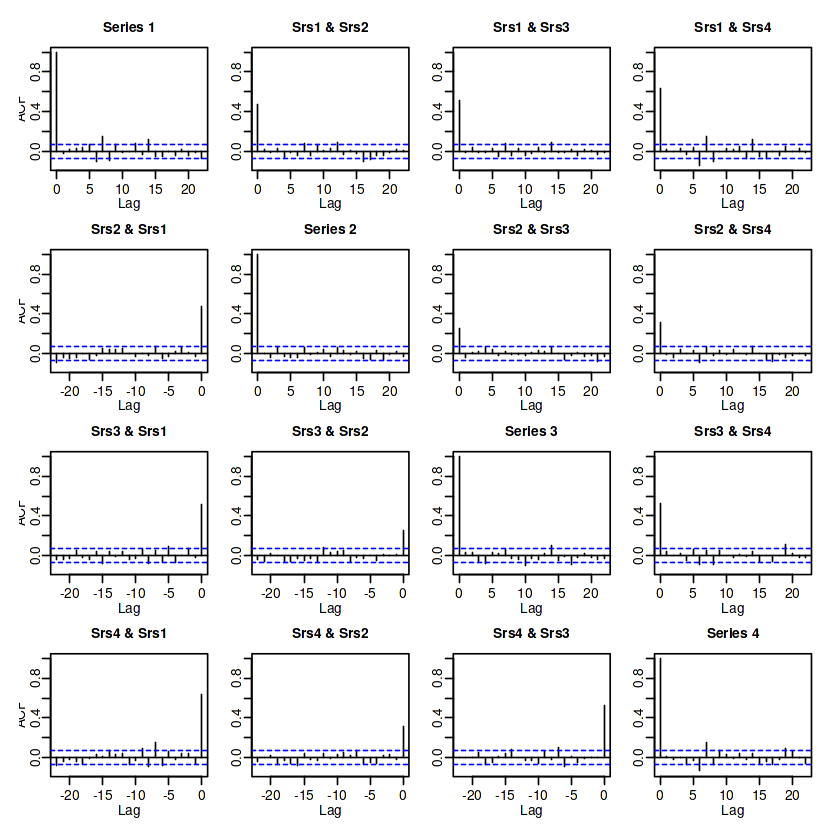

In [56]:
#Se visualiza nuevamente los residuales, donde se puede observar la mejoría respecto al modelo completo.
acf(resi2)

In [58]:
# Se aplica la función de diagnóstico al modelo terminal lo que permite observar si existe una dependencia inmediata en las series.
MTSdiag(m2, adj=10) 

[1] "Covariance matrix:"
         ryld     tsla       tm       gm
ryld 1.54e-04 0.000249 9.54e-05 0.000225
tsla 2.49e-04 0.001837 1.63e-04 0.000387
tm   9.54e-05 0.000163 2.23e-04 0.000223
gm   2.25e-04 0.000387 2.23e-04 0.000815
CCM at lag:  0 
      [,1]  [,2]  [,3]  [,4]
[1,] 1.000 0.469 0.515 0.635
[2,] 0.469 1.000 0.254 0.316
[3,] 0.515 0.254 1.000 0.523
[4,] 0.635 0.316 0.523 1.000
Simplified matrix: 
CCM at lag:  1 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  2 
. . . . 
. . . . 
+ . . . 
. . . . 
CCM at lag:  3 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  4 
. . . . 
. . . . 
. . - . 
. . . . 
CCM at lag:  5 
. . . . 
. . . . 
+ . . . 
. . . . 
CCM at lag:  6 
- . . - 
. . . - 
. . . - 
- . - - 
CCM at lag:  7 
+ + + + 
. . . . 
. . . . 
+ . + + 
CCM at lag:  8 
- . . - 
. . . . 
- . . - 
- . . . 
CCM at lag:  9 
. . . . 
. . . . 
. . . . 
+ . . + 
CCM at lag:  10 
. . . . 
. . . . 
. . - . 
. . . . 
CCM at lag:  11 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  12

Se puede observar que no existen correlaciones instantáneas entre las series, ya que los p-valores de la matriz de CCM lag 0, son mayores a la significancia del 5%.

### Análisis impulso respuesta

Con base en los modelos construidos anteriormente se procede a realizar un analisis impulso respuesta

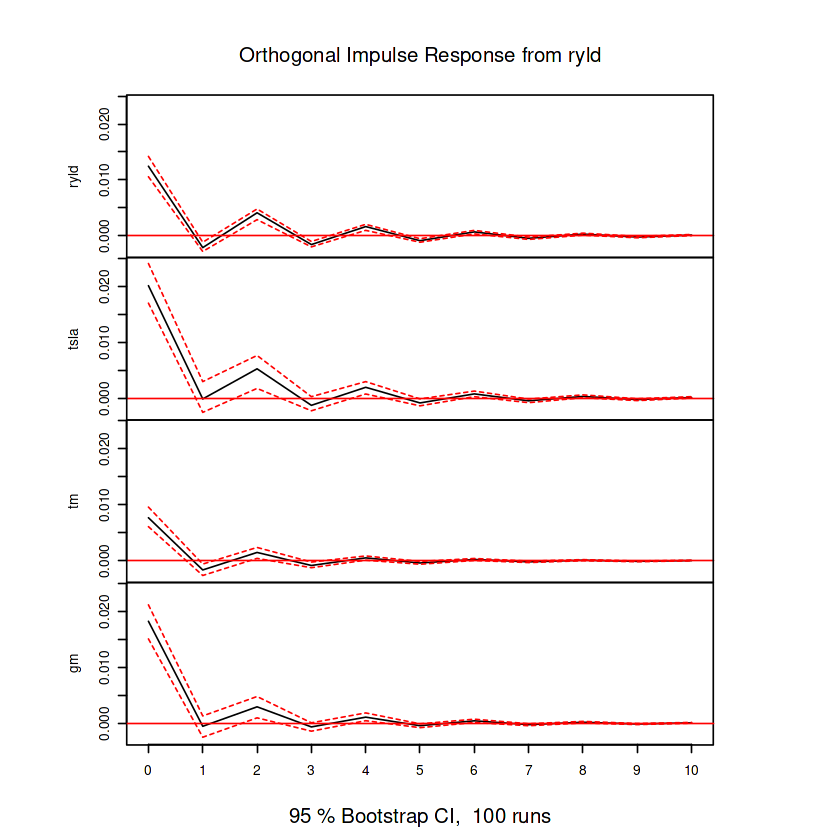

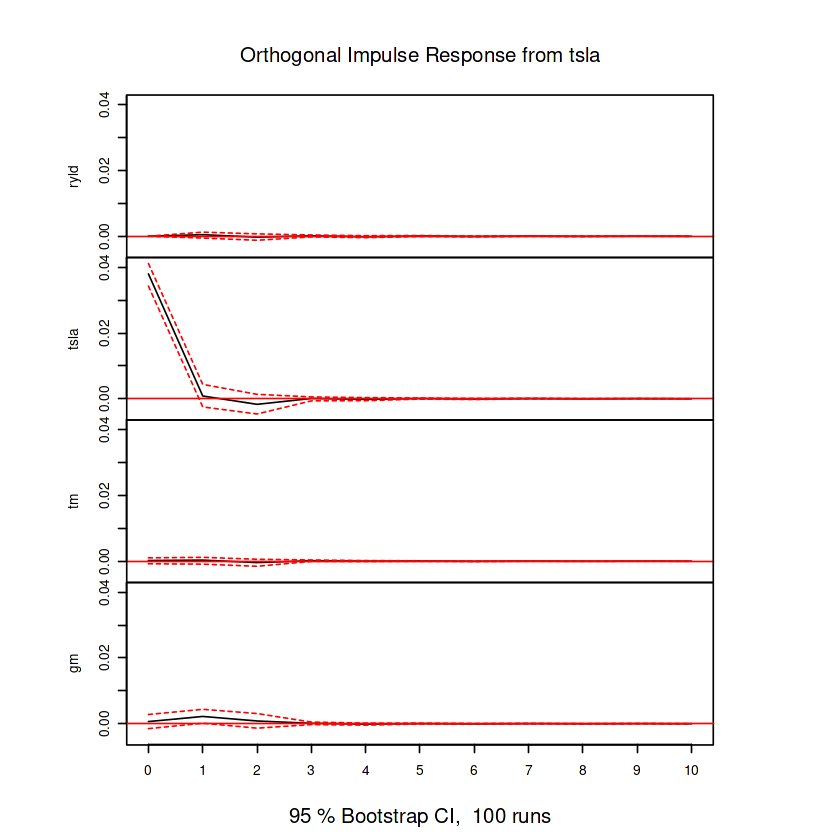

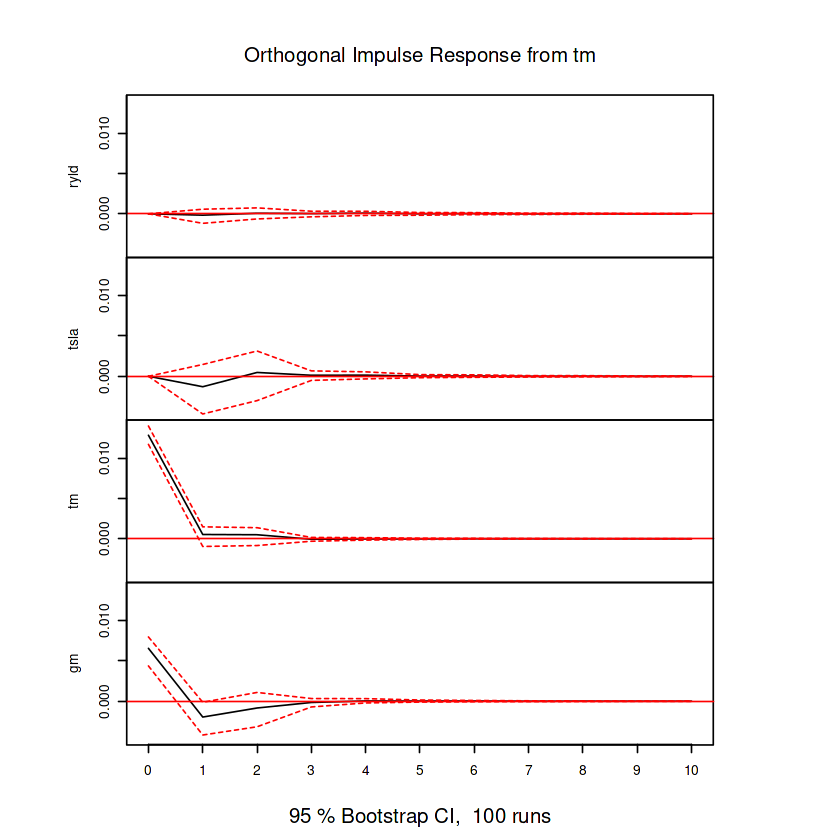

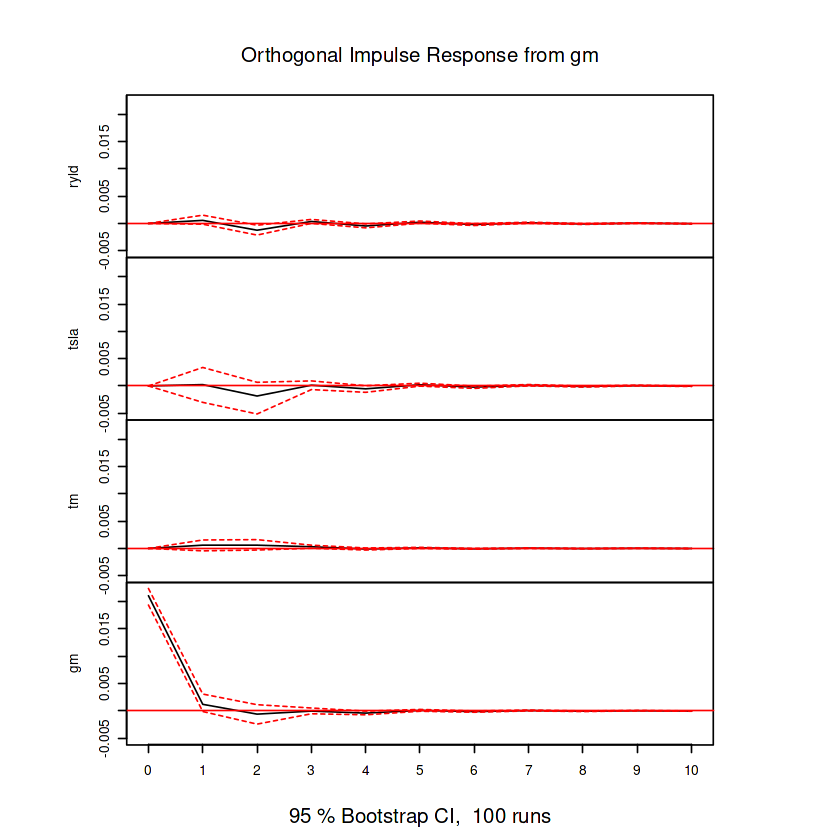

In [60]:
# La función de impulso respuesta se lleva a cabo mediante la librería de vars. La función es la irf(). Se aplica la función al primer modelo.
m1irf = irf(m0, n.ahead = 10, boot = TRUE)
plot(m1irf) 

Se puede observar que 

### Predicción

Se realiza la predicción para cada uno de los modelos generados

In [106]:
## Se realiza la predicción para los modelos generados con MTS
predm1=VARpred(m1, 10) ## Se genera una predicción de diez días en adelante  
var_est1 <- vars::VAR(y=z, lag.max = 2)
summary(var_est1)

orig  745 
Forecasts at origin:  745 
            ryld     tsla        tm        gm
 [1,]  3.059e-03 0.009321 4.509e-04 2.809e-03
 [2,]  5.173e-04 0.004595 5.772e-05 1.531e-03
 [3,]  8.202e-04 0.005512 6.255e-04 9.756e-04
 [4,] -9.571e-05 0.004343 4.498e-04 2.476e-04
 [5,]  2.224e-04 0.004547 6.007e-04 3.488e-04
 [6,] -1.334e-04 0.004129 4.863e-04 1.021e-04
 [7,]  4.607e-05 0.004300 5.648e-04 1.898e-04
 [8,] -1.059e-04 0.004129 5.112e-04 9.373e-05
 [9,] -1.539e-05 0.004221 5.479e-04 1.428e-04
[10,] -8.345e-05 0.004147 5.229e-04 1.016e-04
Standard Errors of predictions:  
         [,1]    [,2]    [,3]    [,4]
 [1,] 0.01237 0.04272 0.01487 0.02847
 [2,] 0.01257 0.04275 0.01498 0.02865
 [3,] 0.01328 0.04315 0.01508 0.02883
 [4,] 0.01337 0.04317 0.01511 0.02884
 [5,] 0.01349 0.04322 0.01512 0.02886
 [6,] 0.01352 0.04322 0.01512 0.02886
 [7,] 0.01354 0.04323 0.01512 0.02887
 [8,] 0.01354 0.04323 0.01513 0.02887
 [9,] 0.01355 0.04324 0.01513 0.02887
[10,] 0.01355 0.04324 0.01513 0.02887
Root


VAR Estimation Results:
Endogenous variables: ryld, tsla, tm, gm 
Deterministic variables: const 
Sample size: 743 
Log Likelihood: 7594.66 
Roots of the characteristic polynomial:
0.6839 0.4592 0.2834 0.2834 0.1694 0.1694 0.1552 0.1552
Call:
vars::VAR(y = z, lag.max = 2)


Estimation results for equation ryld: 
ryld = ryld.l1 + tsla.l1 + tm.l1 + gm.l1 + ryld.l2 + tsla.l2 + tm.l2 + gm.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
ryld.l1 -2.104e-01  5.036e-02  -4.177 3.32e-05 ***
tsla.l1  1.215e-02  1.210e-02   1.004   0.3156    
tm.l1   -2.693e-02  3.720e-02  -0.724   0.4693    
gm.l1    2.684e-02  2.160e-02   1.243   0.2143    
ryld.l2  3.596e-01  5.030e-02   7.149 2.11e-12 ***
tsla.l2 -5.524e-03  1.209e-02  -0.457   0.6480    
tm.l2    3.635e-02  3.727e-02   0.975   0.3296    
gm.l2   -5.391e-02  2.129e-02  -2.532   0.0116 *  
const   -7.968e-05  4.630e-04  -0.172   0.8634    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard e

In [107]:
predm2=VARpred(m2, 10) ## Se genera una predicción de diez días en adelante  
var_est2 <- vars::VAR(y=z, lag.max = 2)
summary(var_est2)

orig  745 
Forecasts at origin:  745 
            ryld     tsla         tm        gm
 [1,]  2.838e-03 0.007118 -1.364e-03 0.0023905
 [2,]  5.151e-04 0.005650 -1.687e-04 0.0013685
 [3,]  8.617e-04 0.005435  4.050e-05 0.0009731
 [4,] -2.147e-05 0.004422 -6.007e-05 0.0004048
 [5,]  2.799e-04 0.004573  5.043e-05 0.0004445
 [6,] -7.604e-05 0.004188 -2.144e-05 0.0002358
 [7,]  9.639e-05 0.004319  3.277e-05 0.0002947
 [8,] -5.678e-05 0.004164 -2.699e-06 0.0002128
 [9,]  3.144e-05 0.004239  2.266e-05 0.0002491
[10,] -3.727e-05 0.004173  5.721e-06 0.0002145
Standard Errors of predictions:  
         [,1]    [,2]    [,3]    [,4]
 [1,] 0.01240 0.04283 0.01492 0.02852
 [2,] 0.01258 0.04283 0.01503 0.02868
 [3,] 0.01329 0.04317 0.01512 0.02885
 [4,] 0.01338 0.04318 0.01513 0.02885
 [5,] 0.01349 0.04322 0.01513 0.02887
 [6,] 0.01351 0.04323 0.01514 0.02887
 [7,] 0.01353 0.04323 0.01514 0.02887
 [8,] 0.01354 0.04323 0.01514 0.02887
 [9,] 0.01354 0.04324 0.01514 0.02887
[10,] 0.01355 0.04324 0.01514 0


VAR Estimation Results:
Endogenous variables: ryld, tsla, tm, gm 
Deterministic variables: const 
Sample size: 743 
Log Likelihood: 7594.66 
Roots of the characteristic polynomial:
0.6839 0.4592 0.2834 0.2834 0.1694 0.1694 0.1552 0.1552
Call:
vars::VAR(y = z, lag.max = 2)


Estimation results for equation ryld: 
ryld = ryld.l1 + tsla.l1 + tm.l1 + gm.l1 + ryld.l2 + tsla.l2 + tm.l2 + gm.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
ryld.l1 -2.104e-01  5.036e-02  -4.177 3.32e-05 ***
tsla.l1  1.215e-02  1.210e-02   1.004   0.3156    
tm.l1   -2.693e-02  3.720e-02  -0.724   0.4693    
gm.l1    2.684e-02  2.160e-02   1.243   0.2143    
ryld.l2  3.596e-01  5.030e-02   7.149 2.11e-12 ***
tsla.l2 -5.524e-03  1.209e-02  -0.457   0.6480    
tm.l2    3.635e-02  3.727e-02   0.975   0.3296    
gm.l2   -5.391e-02  2.129e-02  -2.532   0.0116 *  
const   -7.968e-05  4.630e-04  -0.172   0.8634    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard e

### Pronóstico 

Se realiza el pronostico a 10 días

In [137]:
#Se especifica el horizonte de pronóstico.
nhor=10 #pasos en el pronóstico.
nr_lev <- nrow(prices)
mr_lev= as.matrix(prices)
tail(mr_lev)
str(mr_lev)

,RYLD,TSLA,TM,GM
2022-12-22,18.90,125.35,137.00,33.53
2022-12-23,18.95,123.15,137.14,33.83
2022-12-27,18.92,109.10,136.16,33.32
2022-12-28,18.78,112.71,134.13,32.53
2022-12-29,18.84,121.82,137.41,33.67
2022-12-30,18.81,123.18,136.58,33.64


 num [1:933, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:933] "2019-04-22" "2019-04-23" "2019-04-24" "2019-04-25" ...
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


In [138]:
# Se genera la estructura de datos con NAs que se poblarán con los valores de pronóstico, que se irán sumando acumuladamente.
m.varf_lev_ft <- rbind(mr_lev[,1:4], matrix(NA, nhor,4 ))
head(m.varf_lev_ft)
tail(m.varf_lev_ft)

,RYLD,TSLA,TM,GM
2019-04-22,24.995,17.51667,124.16,39.50
2019-04-23,25.157,17.59333,124.94,39.83
2019-04-24,25.189,17.24400,122.88,39.72
2019-04-25,25.130,16.50867,123.19,39.11
2019-04-26,25.225,15.67600,123.62,39.68
2019-04-29,25.250,16.09800,123.81,40.01


,RYLD,TSLA,TM,GM
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA


In [139]:
## Se calcula un z2 con los datos completos
gdp2=log(Pr)
ryld=diff(gdp2[,1],1)
tsla=diff((gdp2[,2]),1)
tm=diff(gdp2[,3],1)
gm=diff(gdp2[,4],1)
z2=cbind.data.frame(ryld,tsla,tm,gm)
head(z2)
str(z2)

,ryld,tsla,tm,gm
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0064603330,0.004367189,0.006262556,0.008319771
2,0.0012711871,-0.020055756,-0.016625395,-0.002765573
3,-0.0023450404,-0.043578712,0.002519652,-0.015476666
4,0.0037732632,-0.051754658,0.003484468,0.014469086
5,0.0009905744,0.026564157,0.001535746,0.008282091
6,-0.0015457310,-0.011579538,-0.001697580,-0.026850589


'data.frame':	932 obs. of  4 variables:
 $ ryld: Time-Series  from 2017 to 2020: 0.00646 0.001271 -0.002345 0.003773 0.000991 ...
 $ tsla: Time-Series  from 2017 to 2020: 0.00437 -0.02006 -0.04358 -0.05175 0.02656 ...
 $ tm  : Time-Series  from 2017 to 2020: 0.00626 -0.01663 0.00252 0.00348 0.00154 ...
 $ gm  : Time-Series  from 2017 to 2020: 0.00832 -0.00277 -0.01548 0.01447 0.00828 ...


In [140]:
m1z2=MTS::VAR(z2,2)
m2z2=refVAR(m1z2,thres = 1.96)

Constant term: 
Estimates:  -0.0002920961 0.002206774 9.422631e-05 -0.0002435995 
Std.Error:  0.0004102673 0.00141526 0.0004999324 0.0009413994 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]    [,2]    [,3]   [,4]
[1,] -0.1911 0.00930 -0.0195 0.0218
[2,] -0.0785 0.01732 -0.0400 0.0040
[3,] -0.1730 0.00435  0.0127 0.0198
[4,] -0.1019 0.04067 -0.1104 0.0347
standard error 
       [,1]   [,2]   [,3]   [,4]
[1,] 0.0450 0.0110 0.0334 0.0196
[2,] 0.1553 0.0378 0.1151 0.0676
[3,] 0.0549 0.0134 0.0407 0.0239
[4,] 0.1033 0.0251 0.0766 0.0450
AR( 2 )-matrix 
       [,1]     [,2]      [,3]     [,4]
[1,] 0.3141 -0.00376  0.010842 -0.04051
[2,] 0.4225 -0.01275  0.037184 -0.01961
[3,] 0.0419 -0.01060  0.000614  0.03387
[4,] 0.2023  0.01742 -0.098789 -0.00843
standard error 
       [,1]   [,2]   [,3]   [,4]
[1,] 0.0450 0.0110 0.0334 0.0194
[2,] 0.1552 0.0379 0.1152 0.0671
[3,] 0.0548 0.0134 0.0407 0.0237
[4,] 0.1033 0.0252 0.0766 0.0446
  
Residuals cov-mtx: 
             [,1]         [,2]     

In [141]:
## Se vuelve a correr el modelo pero esta vez usando los datos completos para pronosticar diez dias en adelante
predmp=VARpred(m2z2, 10) ## Se genera una predicción de diez días en adelante  
var_estp <- vars::VAR(y=prices, lag.max = 2)

orig  932 
Forecasts at origin:  932 
            ryld       tsla         tm         gm
 [1,] -1.058e-04  1.322e-03  1.630e-03  5.973e-04
 [2,] -4.601e-04 -6.603e-04 -2.199e-05 -2.984e-04
 [3,]  1.431e-05 -4.382e-05  8.765e-05 -1.981e-05
 [4,] -1.382e-04 -1.906e-04 -1.419e-05 -8.615e-05
 [5,]  2.711e-05  5.927e-06  1.817e-05  2.679e-06
 [6,] -4.524e-05 -5.726e-05 -7.251e-06 -2.588e-05
 [7,]  1.572e-05  1.123e-05  6.323e-06  5.076e-06
 [8,] -1.598e-05 -1.874e-05 -3.218e-06 -8.472e-06
 [9,]  7.359e-06  6.511e-06  2.402e-06  2.943e-06
[10,] -5.953e-06 -6.620e-06 -1.358e-06 -2.992e-06
Standard Errors of predictions:  
         [,1]    [,2]    [,3]    [,4]
 [1,] 0.01240 0.04279 0.01510 0.02853
 [2,] 0.01255 0.04279 0.01520 0.02853
 [3,] 0.01308 0.04309 0.01526 0.02862
 [4,] 0.01313 0.04310 0.01527 0.02862
 [5,] 0.01319 0.04313 0.01527 0.02863
 [6,] 0.01320 0.04313 0.01527 0.02863
 [7,] 0.01321 0.04313 0.01527 0.02864
 [8,] 0.01321 0.04313 0.01527 0.02864
 [9,] 0.01322 0.04313 0.01527 0.0286

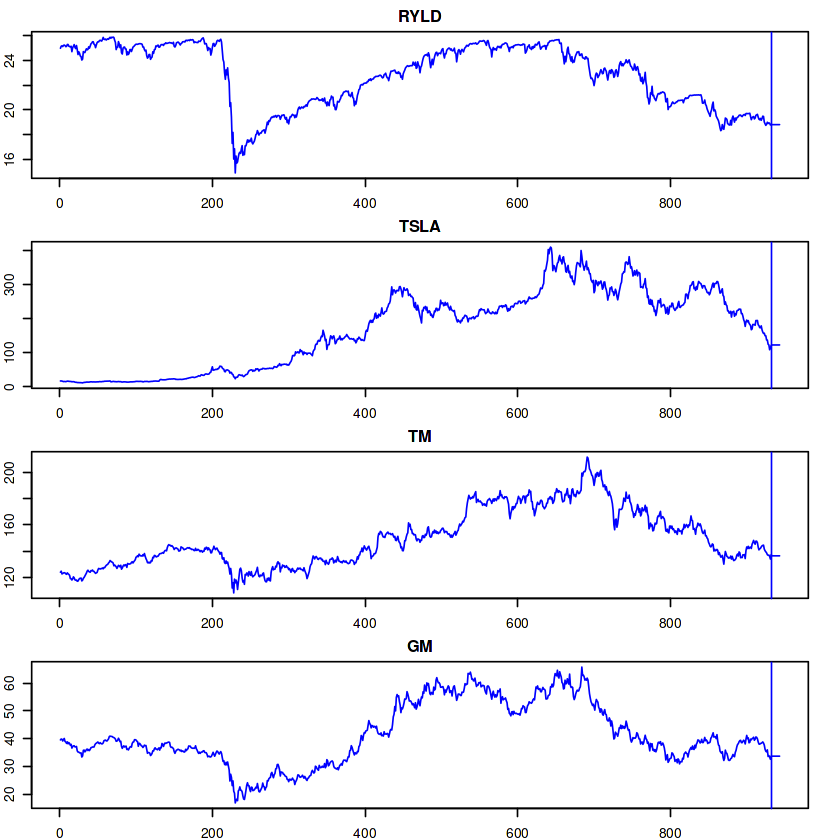

In [142]:
#En la función de recuperación, se especifican los valores que se consideran del modelo seleccionado. Generamos igualmente una visualización del resultado.
nhor=10
m.ft_df <- predmp$pred
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}
str.main=c("RYLD", "TSLA", "TM","GM" )
par(mfrow=c(4,1), mar=c(2,2,2,2))
for(i in 1:4) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="blue")
}

In [143]:
tail(m.varf_lev_ft)

,RYLD,TSLA,TM,GM
,18.80934,123.1804,136.5817,33.64020
,18.80929,123.1804,136.5817,33.64017
,18.80931,123.1804,136.5817,33.64017
,18.80929,123.1804,136.5817,33.64017
,18.80930,123.1804,136.5817,33.64017
,18.80929,123.1804,136.5817,33.64017


### Calculo de metricas de error de pronóstico

Se realiza para m0, m1 y m2

#### M0

In [121]:
## Para m0 se calcula la predicción
h <- round(length(Pr)*0.05, digits = 0 )
h
pred <- predict(m0, n.ahead = h)

[1] 187

In [122]:
pred_values <- pred$fcst
pred_df <- do.call(cbind, lapply(pred_values, function(x) x[, 1]))
colnames(pred_df) <- colnames(z)
head(pred_df)
tail(pred_df)

ryld,tsla,tm,gm
3.058602e-03,0.009320978,4.508842e-04,0.0028094393
5.173299e-04,0.004595156,5.771971e-05,0.0015312779
8.201712e-04,0.005512457,6.255458e-04,0.0009755968
-9.570639e-05,0.004342526,4.498184e-04,0.0002475711
2.223573e-04,0.004547192,6.007329e-04,0.0003487799
-1.334320e-04,0.004129374,4.862741e-04,0.0001021082


,ryld,tsla,tm,gm
"[182,]",-5.892588e-05,0.004170809,0.0005331117,0.0001144401
"[183,]",-5.892588e-05,0.004170809,0.0005331117,0.0001144401
"[184,]",-5.892588e-05,0.004170809,0.0005331117,0.0001144401
"[185,]",-5.892588e-05,0.004170809,0.0005331117,0.0001144401
"[186,]",-5.892588e-05,0.004170809,0.0005331117,0.0001144401
"[187,]",-5.892588e-05,0.004170809,0.0005331117,0.0001144401


In [124]:
# Se definen las funciones para RMSE y MAE
rmse <- function(pred, obs) {
  sqrt(mean((pred - obs)^2))
}

mae <- function(pred, obs) {
  mean(abs(pred - obs))
}

# Se toman los vectores
rmse_values <- numeric(ncol(pred_df))
mae_values <- numeric(ncol(pred_df))

# Calcular RMSE y MAE para cada serie
for (i in 1:ncol(pred_df)) {
  rmse_values[i] <- rmse(pred_df[, i], Pr_tes[, i])
  mae_values[i] <- mae(pred_df[, i], Pr_tes[, i])
}

# Agregar nombres de columnas apropiados
names(rmse_values) <- colnames(z)
names(mae_values) <- colnames(z)

# Imprimir los resultados
print("RMSE values:")
print(rmse_values)

print("MAE values:")
print(mae_values)

[1] "RMSE values:"
     ryld      tsla        tm        gm 
 20.48085 251.67741 152.23911  37.09965 
[1] "MAE values:"
     ryld      tsla        tm        gm 
 20.44067 245.88909 151.73738  36.98884 


#### M1

In [125]:
## Se calcula de nuevo la predicción esta vez cubriendo todos los datos de test
h <- round(length(Pr)*0.05, digits = 0 )
h
predm1=VARpred(m1, h)  
var_est1 <- vars::VAR(y=z, lag.max = 2)
#summary(var_est1)

[1] 187

orig  745 
Forecasts at origin:  745 
             ryld     tsla        tm        gm
  [1,]  3.059e-03 0.009321 4.509e-04 2.809e-03
  [2,]  5.173e-04 0.004595 5.772e-05 1.531e-03
  [3,]  8.202e-04 0.005512 6.255e-04 9.756e-04
  [4,] -9.571e-05 0.004343 4.498e-04 2.476e-04
  [5,]  2.224e-04 0.004547 6.007e-04 3.488e-04
  [6,] -1.334e-04 0.004129 4.863e-04 1.021e-04
  [7,]  4.607e-05 0.004300 5.648e-04 1.898e-04
  [8,] -1.059e-04 0.004129 5.112e-04 9.373e-05
  [9,] -1.539e-05 0.004221 5.479e-04 1.428e-04
 [10,] -8.345e-05 0.004147 5.229e-04 1.016e-04
 [11,] -3.974e-05 0.004192 5.401e-04 1.262e-04
 [12,] -7.094e-05 0.004158 5.284e-04 1.078e-04
 [13,] -5.020e-05 0.004180 5.364e-04 1.196e-04
 [14,] -6.466e-05 0.004165 5.309e-04 1.112e-04
 [15,] -5.490e-05 0.004175 5.346e-04 1.168e-04
 [16,] -6.163e-05 0.004168 5.321e-04 1.129e-04
 [17,] -5.705e-05 0.004173 5.338e-04 1.155e-04
 [18,] -6.020e-05 0.004169 5.326e-04 1.137e-04
 [19,] -5.805e-05 0.004172 5.334e-04 1.149e-04
 [20,] -5.952e-05 0.00

In [126]:
## Se calcula de nuevo nlever pero esta vez desde los datos de entrenamiento
nhor=h
nr_lev <- nrow(Pr_tra)
mr_lev= as.matrix(Pr_tra)
tail(mr_lev)
str(mr_lev)

,RYLD,TSLA,TM,GM
"[741,]",23.83,363.9467,177.85,44.22
"[742,]",24.06,366.5233,184.81,46.26
"[743,]",23.88,364.6633,180.62,45.22
"[744,]",23.81,359.2000,180.25,43.74
"[745,]",23.97,361.5300,180.37,42.96
"[746,]",24.05,381.8167,182.58,43.18


 num [1:746, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


In [127]:
## se genera de nuevo la sección con NAs que seran el equivalente a la sección de datos de test
h <- round(length(Pr)*0.05, digits = 0 )
h
m.varf_lev_ft <- rbind(mr_lev[,1:4], matrix(NA, h,4 ))
head(m.varf_lev_ft)
tail(m.varf_lev_ft)

[1] 187

RYLD,TSLA,TM,GM
24.995,17.51667,124.16,39.50
25.157,17.59333,124.94,39.83
25.189,17.24400,122.88,39.72
25.130,16.50867,123.19,39.11
25.225,15.67600,123.62,39.68
25.250,16.09800,123.81,40.01


,RYLD,TSLA,TM,GM
"[928,]",NA,NA,NA,NA
"[929,]",NA,NA,NA,NA
"[930,]",NA,NA,NA,NA
"[931,]",NA,NA,NA,NA
"[932,]",NA,NA,NA,NA
"[933,]",NA,NA,NA,NA


In [128]:
m.ft_df <- predm1$pred
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}

In [130]:
head(m.varf_lev_ft)
tail(m.varf_lev_ft)

RYLD,TSLA,TM,GM
24.995,17.51667,124.16,39.50
25.157,17.59333,124.94,39.83
25.189,17.24400,122.88,39.72
25.130,16.50867,123.19,39.11
25.225,15.67600,123.62,39.68
25.250,16.09800,123.81,40.01


,RYLD,TSLA,TM,GM
"[928,]",24.04411,382.5833,182.6765,43.20624
"[929,]",24.04405,382.5875,182.6771,43.20635
"[930,]",24.04399,382.5917,182.6776,43.20646
"[931,]",24.04393,382.5958,182.6781,43.20658
"[932,]",24.04387,382.6000,182.6787,43.20669
"[933,]",24.04381,382.6042,182.6792,43.20681


In [129]:
# Inicializar vectores para almacenar los resultados
rmse_values <- numeric(ncol(m.varf_lev_ft))
mae_values <- numeric(ncol(m.varf_lev_ft))

# Calcular RMSE y MAE para cada serie
for (i in 1:ncol(m.varf_lev_ft)) {
  rmse_values[i] <- rmse(m.varf_lev_ft[(nr_lev + 1):(nr_lev + nhor), i], Pr_tes[, i])
  mae_values[i] <- mae(m.varf_lev_ft[(nr_lev + 1):(nr_lev + nhor), i], Pr_tes[, i])
}

# Imprimir los resultados
names(rmse_values) <- str.main
names(mae_values) <- str.main

print("RMSE values:")
print(rmse_values)

print("MAE values:")
print(mae_values)

[1] "RMSE values:"
      RYLD       TSLA         TM         GM 
  3.828781 146.563386  33.278110   6.836653 
[1] "MAE values:"
      RYLD       TSLA         TM         GM 
  3.608632 136.322958  30.891693   6.207154 


#### M2

In [112]:
## Se calcula de nuevo la predicción esta vez cubriendo todos los datos de test
h <- round(length(Pr)*0.05, digits = 0 )
h
predm2=VARpred(m2, h)  
var_est2 <- vars::VAR(y=z, lag.max = 2)
#summary(var_est2)

[1] 187

orig  745 
Forecasts at origin:  745 
             ryld     tsla         tm        gm
  [1,]  2.838e-03 0.007118 -1.364e-03 0.0023905
  [2,]  5.151e-04 0.005650 -1.687e-04 0.0013685
  [3,]  8.617e-04 0.005435  4.050e-05 0.0009731
  [4,] -2.147e-05 0.004422 -6.007e-05 0.0004048
  [5,]  2.799e-04 0.004573  5.043e-05 0.0004445
  [6,] -7.604e-05 0.004188 -2.144e-05 0.0002358
  [7,]  9.639e-05 0.004319  3.277e-05 0.0002947
  [8,] -5.678e-05 0.004164 -2.699e-06 0.0002128
  [9,]  3.144e-05 0.004239  2.266e-05 0.0002491
 [10,] -3.727e-05 0.004173  5.721e-06 0.0002145
 [11,]  5.916e-06 0.004211  1.758e-05 0.0002335
 [12,] -2.564e-05 0.004181  9.552e-06 0.0002182
 [13,] -4.917e-06 0.004200  1.511e-05 0.0002276
 [14,] -1.958e-05 0.004186  1.132e-05 0.0002206
 [15,] -9.739e-06 0.004195  1.394e-05 0.0002252
 [16,] -1.660e-05 0.004189  1.215e-05 0.0002219
 [17,] -1.194e-05 0.004193  1.338e-05 0.0002241
 [18,] -1.516e-05 0.004190  1.254e-05 0.0002226
 [19,] -1.297e-05 0.004192  1.311e-05 0.0002236
 [


VAR Estimation Results:
Endogenous variables: ryld, tsla, tm, gm 
Deterministic variables: const 
Sample size: 743 
Log Likelihood: 7594.66 
Roots of the characteristic polynomial:
0.6839 0.4592 0.2834 0.2834 0.1694 0.1694 0.1552 0.1552
Call:
vars::VAR(y = z, lag.max = 2)


Estimation results for equation ryld: 
ryld = ryld.l1 + tsla.l1 + tm.l1 + gm.l1 + ryld.l2 + tsla.l2 + tm.l2 + gm.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
ryld.l1 -2.104e-01  5.036e-02  -4.177 3.32e-05 ***
tsla.l1  1.215e-02  1.210e-02   1.004   0.3156    
tm.l1   -2.693e-02  3.720e-02  -0.724   0.4693    
gm.l1    2.684e-02  2.160e-02   1.243   0.2143    
ryld.l2  3.596e-01  5.030e-02   7.149 2.11e-12 ***
tsla.l2 -5.524e-03  1.209e-02  -0.457   0.6480    
tm.l2    3.635e-02  3.727e-02   0.975   0.3296    
gm.l2   -5.391e-02  2.129e-02  -2.532   0.0116 *  
const   -7.968e-05  4.630e-04  -0.172   0.8634    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard e

In [114]:
## Se calcula de nuevo nlever pero esta vez desde los datos de entrenamiento
nhor=h
nr_lev <- nrow(Pr_tra)
mr_lev= as.matrix(Pr_tra)
tail(mr_lev)
str(mr_lev)

,RYLD,TSLA,TM,GM
"[741,]",23.83,363.9467,177.85,44.22
"[742,]",24.06,366.5233,184.81,46.26
"[743,]",23.88,364.6633,180.62,45.22
"[744,]",23.81,359.2000,180.25,43.74
"[745,]",23.97,361.5300,180.37,42.96
"[746,]",24.05,381.8167,182.58,43.18


 num [1:746, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


In [115]:
## se genera de nuevo la sección con NAs que seran el equivalente a la sección de datos de test
h <- round(length(Pr)*0.05, digits = 0 )
h
m.varf_lev_ft <- rbind(mr_lev[,1:4], matrix(NA, h,4 ))
head(m.varf_lev_ft)
tail(m.varf_lev_ft)

[1] 187

RYLD,TSLA,TM,GM
24.995,17.51667,124.16,39.50
25.157,17.59333,124.94,39.83
25.189,17.24400,122.88,39.72
25.130,16.50867,123.19,39.11
25.225,15.67600,123.62,39.68
25.250,16.09800,123.81,40.01


,RYLD,TSLA,TM,GM
"[928,]",NA,NA,NA,NA
"[929,]",NA,NA,NA,NA
"[930,]",NA,NA,NA,NA
"[931,]",NA,NA,NA,NA
"[932,]",NA,NA,NA,NA
"[933,]",NA,NA,NA,NA


In [117]:
m.ft_df <- predm2$pred
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}

In [118]:
head(m.varf_lev_ft)
tail(m.varf_lev_ft)

RYLD,TSLA,TM,GM
24.995,17.51667,124.16,39.50
25.157,17.59333,124.94,39.83
25.189,17.24400,122.88,39.72
25.130,16.50867,123.19,39.11
25.225,15.67600,123.62,39.68
25.250,16.09800,123.81,40.01
25.211,15.91267,123.60,38.95
25.124,15.60067,122.92,38.75
25.141,16.27333,122.59,38.25
25.300,17.00200,123.65,38.80


In [119]:
# Calcular RMSE y MAE para cada serie
rmse <- function(pred, obs) {
  sqrt(mean((pred - obs)^2))
}

mae <- function(pred, obs) {
  mean(abs(pred - obs))
}

# Inicializar vectores para almacenar los resultados
rmse_values <- numeric(ncol(m.varf_lev_ft))
mae_values <- numeric(ncol(m.varf_lev_ft))

# Calcular RMSE y MAE para cada serie
for (i in 1:ncol(m.varf_lev_ft)) {
  rmse_values[i] <- rmse(m.varf_lev_ft[(nr_lev + 1):(nr_lev + nhor), i], Pr_tes[, i])
  mae_values[i] <- mae(m.varf_lev_ft[(nr_lev + 1):(nr_lev + nhor), i], Pr_tes[, i])
}

# Imprimir los resultados
names(rmse_values) <- str.main
names(mae_values) <- str.main

print("RMSE values:")
print(rmse_values)

print("MAE values:")
print(mae_values)

[1] "RMSE values:"
      RYLD       TSLA         TM         GM 
  3.833243 146.564379  33.222549   6.845250 
[1] "MAE values:"
      RYLD       TSLA         TM         GM 
  3.612617 136.323715  30.841709   6.216533 
